In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import numba as nb

def find_minmax(x,d):
    #### Locate min and max
    ## this works b/c the diffusion slope should be biggest
    dddx = np.gradient(d)
    iright = np.argmin(dddx)
    ileft = np.argmax(dddx[:iright])
    imax = np.argmin(np.abs(dddx[ileft:iright]))+ileft
    imin = np.argmin(d[:imax])
    return imin,imax
    
def render_gc(x,lnrho0,lam_G,xmin,lam):
    xm = xmin - 1./lam*np.log(lam_G/(lam-lam_G))
    q1 = np.exp(lnrho0-lam_G*(x-xm))
    q2 = np.exp(lnrho0+(lam-lam_G)*(x-xm))
    rho = q1+q2
    # rho[np.isnan(rho)] = 0.
    return rho

def render_d(x,imax,lnrho1,lam_D):
    rho = np.exp(lnrho1 - lam_D*(x-x[imax]))
    # rho[np.isnan(rho)] = 0.
    return rho

def render_bg(x,a,b,c):
    rho = a*x**2.+b*x+c
    return rho

def cost(theta,x,rho_obs,imin,imax):
    lnrho0,lam_G,xmin,lam,lnrho1,lam_D,bg_a,bg_b,bg_c,xignore1,xignore2 = theta 

    ## Check fitting boundaries
    if xmin < 0. or xmin > x[imax]: ## min location is prior to the peak
        return np.inf 
    elif lam_G < 0 or lam <= lam_G or lam_D < 0: ## all slopes are positive. Direction defined in density fxns
        return np.inf  
    elif bg_c > rho_obs[imin]: ## the SS background can't be higher than the min density 
        return np.inf
    elif xignore1 <= 0 or xignore1 >= x[imin]: ## GC: only look before the peak
        return np.inf
    elif xignore2 <= x[imax] or xignore2 > x[-1]: ## D: only look past the peak
        return np.inf
    elif rho_obs[np.argmax(x>xignore2)]<.8*rho_obs[imax]: ## D: don't ignore more than 20% of the peak
        return np.inf

    ## Render the fitting curves
    bg = render_bg(x,bg_a,bg_b,bg_c) 
    rho_gc = render_gc(x,lnrho0,lam_G,xmin,lam) + bg
    rho_d = render_d(x,imax,lnrho1,lam_D) + bg

    ## Score the fit
    keep1 = np.bitwise_and(x>xignore1,x<x[imax])
    z1 = np.sqrt(np.nanmean(np.square((rho_obs - rho_gc)[keep1])))
    keep2 = np.bitwise_and(x>xignore2,x==x)
    z2 = np.sqrt(np.nanmean(np.square((rho_obs -  rho_d)[keep2])))
    return z1+z2

def estimate_theta(x,d,skip=5,project=5,imin=None,imax=None):
    ''' 
    Theta - parameters
    -------
    lnrho0: prefactor for GC curve
    lam_G: slope of the G curve in the GC region
    xmin: location of minimum in GC region. Used to solve for xm.
    lam: slope of the attractant in the C region
    lndpre: prefactor in the D curve
    lam_D: slope of the D curve
    bg_a: quadratic term in bg curve
    bg_b: linear term in bg curve
    bg_c: steady term in bg curve
    xignore1: cutoff (in x) for datapoints at start to ingnore (e.g., b/c of a stab artifact)
    xignore2: cutoff (in x) for datapoints after peak max to ignore (i.e., b/c no expression for turnover)
    '''
    _imin,_imax = find_minmax(x,d)
    if imin is None:
        imin = _imin
    if imax is None:
        imax = _imax
    
    est_bg = np.min(d) - 1e-6 ## steady level bg

    ## linear fits to ln(density). polyfit 0 is slope, 1 is yint.
    residual = np.log(d - est_bg)
    pfit_1 = np.polyfit(x[imin-skip-project:imin-skip],residual[imin-skip-project:imin-skip],1) ## Growth
    pfit_2 = np.polyfit(x[imin+skip:imin+skip+project],residual[imin+skip:imin+skip+project],1) ## Chemotxis
    pfit_3 = np.polyfit(x[imax+skip:imax+skip+project],residual[imax+skip:imax+skip+project],1) ## Diffusion
    # ax.plot(x,np.exp(pfit_1[0]*x+pfit_1[1])+est_bg)
    # ax.plot(x,np.exp(pfit_2[0]*x+pfit_2[1])+est_bg)
    # ax.plot(x,np.exp(pfit_3[0]*x+pfit_3[1])+est_bg)

    ## These must be positive -- direction determerined in density equation 
    lam_G = np.abs(pfit_1[0]) ## growth curve
    lam_2 = pfit_2[0]
    lam = lam_G+lam_2 ## attractant curve
    lam_D = np.abs(pfit_3[0]) ## diffusion curve

    xmin = x[imin]
    xm = xmin - 1./lam*np.log(lam_G/(lam-lam_G))  ## This is the analytical value. Get by differenting rho_GC
    rho0 = (d[imin]-est_bg)/((1.+lam_G/(lam-lam_G))*np.exp((lam-lam_G)/lam*np.log((lam-lam_G)/lam))) ## Solve prefactor by plugging in xm
    lnrho0 = np.log(rho0) ## use ln(prefactor) in fitting

    lndpre = np.log(d[imax]-est_bg)
    
    xignore1 = 0.02 * (x[-1]-x[0]) ## 1/10th of the span
    xignore2 = x[imax]+xignore1 ## peak + 10th of the span

    theta = np.array((lnrho0,lam_G,xmin,lam,lndpre,lam_D,0.,0.,est_bg,xignore1,xignore2))
    return theta

def qcfit(x,d,theta,imin=None,imax=None,maxiter=10,verbose=True):
    _imin,_imax = find_minmax(x,d)
    if imin is None:
        imin = _imin
    if imax is None:
        imax = _imax
        
    it = 0
    while it < maxiter:
        it += 1
        out = optimize.minimize(cost,theta,args=(x,d,imin,imax),method='Nelder-mead')
        theta = out.x
        if verbose:
            print(it,out.success,out.fun)
        if out.success:
            break
    if verbose:
        print(out)
    return out.x

def plot_model(x,d,theta,imin=None,imax=None,skip=0):
    _imin,_imax = find_minmax(x,d)
    if imin is None:
        imin = _imin
    if imax is None:
        imax = _imax
        
    fitted_gc = render_gc(x,theta[0],theta[1],theta[2],theta[3])
    # fitted_gc[imax-skip:] = np.nan ## remove out-of-region points from plot
    
    fitted_d = render_d(x,imax,theta[4],theta[5])
    # fitted_d[:imax+skip] = np.nan ## remove out-of-region points from plot
    
    fitted_bg = render_bg(x,theta[6],theta[7],theta[8])

    fig,ax=plt.subplots(1,figsize=(4,3))
    
    ax.plot(x,d,label='Data')
    ylim = ax.get_ylim()
    
    ax.plot(x,fitted_gc+fitted_bg,label='Growth-Chemotaxis')
    ax.plot(x,fitted_d+fitted_bg,label='Diffusion')
    ax.plot(x,fitted_bg,label='Background')
    
    ax.axvspan(x[0],theta[9],alpha=.1,zorder=-2,color='k')
    ax.axvline(theta[2],color='k',zorder=-2)
    ax.axvspan(x[imax],theta[10],alpha=.1,zorder=-2,color='k')

    ax.legend()
    ax.set_xlim(x[0],x[-1])
    ax.set_ylim(0,ylim[1])
    ax.set_ylabel('Absorption (OD)')
    ax.set_xlabel('Radial Distance (mm)')
    ax.set_title(r'Chemotactic Sensitivity, $\phi=%.4f$'%(theta[5]/theta[3]))
    fig.tight_layout()
    return fig,ax
    
def report_info(theta):
    lam_G = theta[1]
    lam = theta[3]
    lam_D = theta[5]
    
    rhomin = render_gc(theta[2],*theta[:4])
    # print(lam_G,lam,lam_D)
    
    phi = lam_D/lam
    r_Drho = lam_G*lam_D
    r_chiDrho = lam*lam_G
    
    print('Chemotactic Sensitivity,           phi = %.4f'%(phi))
    print('rho_min,                      r*a_0/mu = %.4f'%(rhomin))
    print('Growth vs motility,            r/D_rho = %.4f'%(r_Drho))
    print('Growth vs excess taxis, r/(chi0-D_rho) = %.4f'%(r_chiDrho))


## Summary
This follows the work of Narla, Cremer, Hwa in PNAS 2021 "A traveling-wave solution for bacterial chemotaxis with growth", which provides analytical approximations to some points from an earlier work Cremer... Hwa Nature 2019 "Chemotaxis as a navigation strategy to boost range expansion". 

There are three zones (Growth, Chemotaxis, and Diffusion) with a density minimum between the first two, and a peak maximum between the second two.

Narla et al provide an expression for the bacterial density in the Growth and Chemotaxis regimes (GC) (see Eqn. 38). It is a sum of two exponentials that have linear arguments in $z=x-ct$. At a single time point, we can just consider $x$ because it's a function of $t$. This expression is valid (under certain approximations) from $x = 0$ to $x\approx x_{max}$. There is one complication with real data -- the region near the origin of the rings seems to be very structured (e.g., maybe because of artifacts due to stabbing the agar when depositing the cells initially). To work around this, we define an edge where the GC expression (Eqn. 38) 'turns on', and ignore the region before this point. Additionally, our scans of the plates have a background absorption (e.g., from the media). So we also include a background term across the entire distance. This is treated as a second-order polynomial that is relatively flat, and we make sure that the 0th order term is never higher than that density minimum at $x_{min}$. For the fitting of Eqn. 38, we parameterize it using four parameters $\theta = \{ ln(\rho_0), \lambda_G, x_{min}, \lambda \}$, where the first parameter is an adjustable prefactor. Eqn. 38 doesn't have $x_{min}$, but we use it to calcuate $x_m$ (i.e., the analog of $z_m$ at the current time point) as 

$$ x_m = x_{min} - \frac{1}{\lambda}\ln \frac{\lambda_G}{\lambda-\lambda_G} $$,

which is obtained by taking the derivative of Eqn. 38 and finding the minimum. 

For the Diffusion zone, we use Eqn. 27 but solve for parameters $\theta = \{ ln(\rho_1), \lambda_D\}$, where the index change to the prefactor is to distinghish from the prefactor used in the GC region. Similarly, we define a boundary for the data that we ignore while fitting. This boundary is constrained to be to the right of the peak, and cannot exclude more than 20% of the peak from the fitting procedure -- this is necessary because we don't have an expression for the turn over region between C and D at the peak maximum.

We simultaneously fit all parameters $\theta = \{ ln(\rho_0), \lambda_G, x_{min}, \lambda, ln(\rho_1), \lambda_D, bg_a, bg_b, bg_c, x_1, x_2 \}$, where the bg variables are the coefficients of the background polynomial and the $x_i$ are the locations of the boundaries for the GC and D regions, respectively, discussed above. Initial guesses are obtained by locating the maximum at the peak and then the minimum in the trough next to the peak, and then fitting the linearized data to first-order polynomials in the G, C, and D regions. The slopes of these fits ($m_g$, $m_c$, and $m_d$) are related to the $\lambda$ as:
* $\lambda_G = - m_g$
* $\lambda = m_c - m_g$
* $\lambda_D = -m_d$

This ensures that all of the $\lambda$ are postive -- their signs are explicitly included in the density equations (Eqns. 38 and 27).


## Results

Finally, we can use combinations of the $\lambda$ to extract ratios of the relevant parameters. Of particular interest is the chemotactic sensitivity (i.e., a normalized, unitless version of the chemotactic sensitivity coefficient) as defined on pg. 4 of Narla et al.. It is 

$$ \phi \equiv \frac{\chi_0-D_\rho}{D_\rho} = \frac{\lambda_D}{\lambda} $$

Others use the definitions of the $\lambda$s provided in Eqn. 28 and Eqn. 36. Also, Eqn. 53 is accessible. Note that Eqn. 33 is just a scaling, not an equivalency, and Eqn. 44 doesn't actually give us much after we've done the fitting.

## Future
Any future work will need to get time-dependent data and measure the growth rate $r$ using Eqn. 51 (I think...), at which point you can turn the ratios of the $\lambda$s into the individual parameters.

Chemotactic Sensitivity,           phi = 0.8572
rho_min,                      r*a_0/mu = 0.1330
Growth vs motility,            r/D_rho = 9.6569
Growth vs excess taxis, r/(chi0-D_rho) = 11.2651


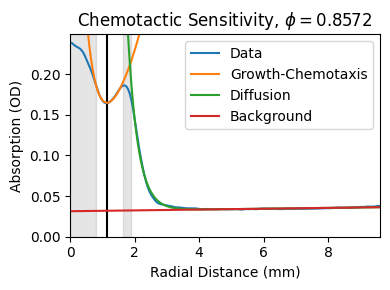

In [2]:
x,_,d = np.loadtxt('data.txt')

theta = estimate_theta(x,d)
for _ in range(50):
    theta = qcfit(x,d,theta,maxiter=100,verbose=False)

report_info(theta)

fig,ax = plot_model(x,d,theta)
plt.savefig('platefit.pdf')